In [3]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from scipy.stats import normaltest
import matplotlib.pyplot as plt
import graphviz

# Import data in csv files

In [4]:
# three files, all in CSV format
movie_dir_df = pd.read_csv("movie_dir_df.csv")


movie_cast_df = pd.read_csv("movie_cast_df.csv")


movies_meta = pd.read_csv("movies_metadata.csv")

C:\Users\josep\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
movie_dir_df

,directors,tmdb_id,rating,vote_count,title,directors_average_rating
0,['Alastair Fothergill'],192040,8.8,176.0,Planet Earth,7.150000
1,['Kenji Mizoguchi'],20532,8.7,68.0,山椒大夫,7.650000
2,['Jonathan Demme'],24128,8.7,47.0,Stop Making Sense,6.457143
3,['Don Hertzfeldt'],86517,8.6,15.0,It's Such a Beautiful Day,8.066667
4,['Dino Risi'],56343,8.6,12.0,Una vita difficile,7.455556
...,...,...,...,...,...,...
8830,"['Herschell Gordon Lewis', 'Bill Rebane']",31119,2.3,14.0,Monster a-Go Go,4.983333
8831,"['""Joe DAmato""']",31264,1.9,15.0,Ator l'invincibile 2,4.471429
8832,['Bob Clark'],31117,1.9,36.0,Superbabies: Baby Geniuses 2,5.430769
8833,['Joe Carnahan'],38700,0.0,12.0,Bad Boys for Life,5.428571


# Sundry data wrangling


In [6]:
# Selected data from each of the three files needs consolidating in one dataframe 
# ahead of analysis

# 'id' used as a the key to join data from each file, vote average the score by movie that is taken to 
# represent its success, and as such is the label we attempt to predict using director and cast data
dir_cast_class_df = movies_meta[['id', 'vote_average']].copy()
dir_cast_class_df['id'] = [x.replace("-", "") for x in dir_cast_class_df['id']]
dir_cast_class_df['id'] = dir_cast_class_df['id'].astype('int')

# map director and cast mean ratings to each movie
movie_dir_dict = dict(zip(movie_dir_df.tmdb_id, movie_dir_df.directors_average_rating))
dir_cast_class_df['dir_mean_rating'] = dir_cast_class_df['id'].map(movie_dir_dict)

movie_cast_dict = dict(zip(movie_cast_df.tmdb_id, movie_cast_df.sum_cast_ratings))
dir_cast_class_df['cast_sum_rating'] = dir_cast_class_df['id'].map(movie_cast_dict)

dir_cast_class_df = dir_cast_class_df.dropna()


In [7]:
# the resulting dataframe
dir_cast_class_df

,id,vote_average,dir_mean_rating,cast_sum_rating
0,862,7.7,6.720000,70.267168
1,8844,6.9,6.200000,74.102614
2,15602,6.5,5.960000,44.330132
4,11862,5.7,5.671429,74.026592
5,949,7.7,6.645455,198.806786
...,...,...,...,...
45436,45527,3.7,4.140000,32.724598
45443,49279,7.6,6.485000,6.561111
45446,49271,6.7,6.485000,6.561111
45450,49280,6.5,6.485000,6.561111


# Examine the data

Mean: 6.34 
StdDev: 0.58 
Dagostino stat: 1111.22 
P: 5.020041262620133e-242


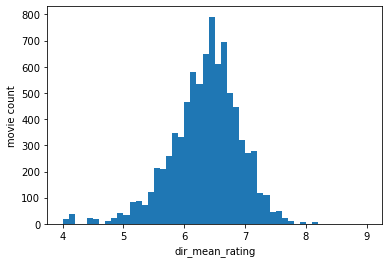

In [34]:
# Director mean rating: Discrete ordinal data, distribution deviates from normal
dir_mean_rating = dir_cast_class_df['dir_mean_rating']
dirrating_hist = plt.hist(dir_mean_rating, bins = 50, range = [4, 9])
dirrating_hist = plt.xlabel('dir_mean_rating')
dirrating_hist= plt.ylabel('movie count')
mu, sigma = norm.fit(dir_mean_rating)
stat, p = normaltest(dir_mean_rating)

print(f'Mean: {round(mu, 2)} \nStdDev: {round(sigma,2)} \nDagostino stat: {round(stat,2)} \nP: {p}')

Mean: 57.0 
StdDev: 42.87 
Dagostino stat: 5899.27 
P: 0.0


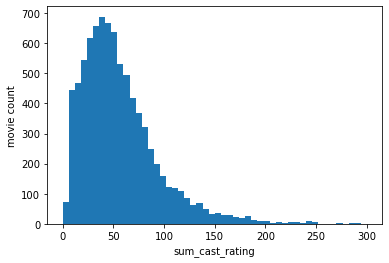

In [35]:
# Sum cast rating by movie: visual left skew and D'agostino p < 0.05 shows data not normally distributed
sum_cast_rating = dir_cast_class_df['cast_sum_rating']
dirrating_hist = plt.hist(sum_cast_rating, bins = 50, range = [0,300])
dirrating_hist = plt.xlabel('sum_cast_rating')
dirrating_hist= plt.ylabel('movie count')
mu, sigma = norm.fit(sum_cast_rating)
stat, p = normaltest(sum_cast_rating)

print(f'Mean: {round(mu, 2)} \nStdDev: {round(sigma,2)} \nDagostino stat: {round(stat,2)} \nP: {p}')

Mean: 6.34 
StdDev: 0.89 
Dagostino stat: 499.94 
P: 2.7453941557584546e-109


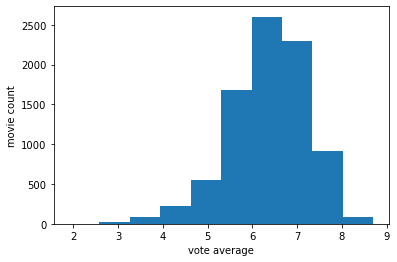

In [37]:
# Target variable - vote average. Discrete ordinal data, deviates from normal distribution
vote_ave_hist = plt.hist(vote_average)
vote_average_hist = plt.xlabel('vote average')
vote_average_hist = plt.ylabel('movie count')
mu, sigma = norm.fit(vote_average)
stat, p = normaltest(vote_average)

print(f'Mean: {round(mu, 2)} \nStdDev: {round(sigma,2)} \nDagostino stat: {round(stat,2)} \nP: {p}')

# Discretize target variable for use in decision tree

In [41]:
# the value that the decision tree tries to predict is a mean value of scores given on an ordinal scale.
# As such, discretizing the data for use in a decision tree seems a reasonable decision
# However in order to use gridsearch CV discretization to 5 bins is required in order to provide sufficient instances in 
# each split, so a decision is made to discretize to 5 scores, recognising that this is somewhat of a compromise
# A decision is required as to how to discretize the data
# - uniform, i.e. each bin has the same size, or kmeans, in which similar scores are grouped, are considered

In [42]:
class_arr = dir_cast_class_df['vote_average'].to_numpy().reshape(-1,1)

In [43]:
disc_uni = KBinsDiscretizer(n_bins = 5, encode = 'ordinal', strategy = 'uniform')
disc_uni.fit(class_arr)
class_arr_ut = disc_uni.transform(class_arr)

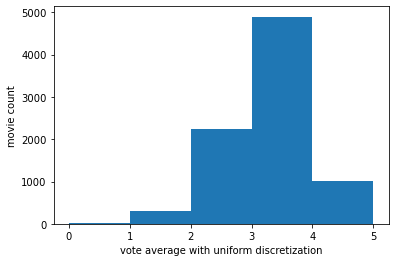

In [44]:
# vote average - the movie average rating, class label. Discretized to 5 to enable Gridsearch CV.
vote_average_hist = plt.hist(class_arr_ut, bins = 5, range = [0, 5])
vote_average_hist = plt.xlabel('vote average with uniform discretization')
vote_average_hist= plt.ylabel('movie count')

In [45]:
# same as above but with kmeans instead of uniform. uniform preserves the actual rating structure.
disc_kmean = KBinsDiscretizer(n_bins = 5, encode = 'ordinal', strategy = 'kmeans')
disc_kmean.fit(class_arr)
class_arr_kt = disc_kmean.transform(class_arr)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


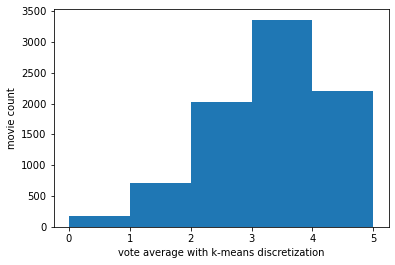

In [46]:
vote_average_hist = plt.hist(class_arr_kt, bins = 5, range = [0, 5])
vote_average_hist = plt.xlabel('vote average with k-means discretization')
vote_average_hist= plt.ylabel('movie count')

# Create decision tree with default parameters

In [47]:
# create input for training algorithm from dataframe. Create test/train splits.
att_arr = dir_cast_class_df[['dir_mean_rating', 'cast_sum_rating']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(att_arr, class_arr_ut, test_size = 0.2, random_state = 42)

In [48]:
# method for consistent evaluation of decision tree results and contribution of each variable to splits
def evaluate_decision_tree (tree, X_train, X_test, y_train, y_test):
    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test) 
    importance = tree.feature_importances_
    print("Depth:", tree.get_depth(), "\nLeaves:", tree.get_n_leaves(), '\nTrain score:', round(train_score, 2), '\nTest score:', round(test_score, 2))
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

In [49]:
# Baseline: with default parameters, uniform discretised classifier and continuous attributes: 
# huge tree, poor validation score
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
evaluate_decision_tree(clf, X_train, X_test, y_train, y_test)

Depth: 38 
Leaves: 2852 
Train score: 1.0 
Test score: 0.51
Feature: 0, Score: 0.42635
Feature: 1, Score: 0.57365


In [50]:
# Experimentally reducing depth of tree improves test and train scores considerably
clf_depth6 = DecisionTreeClassifier(max_depth = 6)
clf_depth6.fit(X_train, y_train)
evaluate_decision_tree(clf_depth6, X_train, X_test, y_train, y_test)

Depth: 6 
Leaves: 59 
Train score: 0.66 
Test score: 0.63
Feature: 0, Score: 0.85239
Feature: 1, Score: 0.14761


# Use gridsearch cv to establish best parameter combination

In [51]:
# An improvement in results was shown in having a smaller tree.
# As a result, cost complexity pruning hyper parameter used to reduce the size of the tree. 
# We're looking for the improvement compared to the baseline, 
# with strong validation score (i.e. similar to train score) suggesting that the tree is not overfitted to the data
params = {'ccp_alpha': [0.0004, 0.0005, 0.0006, 0.0007]} 
clf_gs = GridSearchCV(DecisionTreeClassifier(), params, cv = 3, return_train_score = True, estimator = 'accuracy',)

In [52]:
clf_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.0004, 0.0005, 0.0006, 0.0007]},
             return_train_score=True)

In [53]:
results_df = pd.DataFrame(clf_gs.cv_results_)

In [54]:
# ccp alpha at 0.0006 provides the best validation score
results_df.sort_values(['rank_test_score']).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
3,0.017313,0.002050,0.000665,4.699107e-04,0.0007,{'ccp_alpha': 0.0007},0.639823,0.628761,0.630088,0.632891,0.004932,1,0.651106,0.653982,0.653761,0.652950,0.001307
2,0.014969,0.000013,0.000998,1.123916e-07,0.0006,{'ccp_alpha': 0.0006},0.636283,0.631416,0.628761,0.632153,0.003115,2,0.659292,0.659292,0.662389,0.660324,0.001460
1,0.014872,0.000666,0.000666,4.710923e-04,0.0005,{'ccp_alpha': 0.0005},0.626549,0.611947,0.620354,0.619617,0.005984,3,0.676106,0.677212,0.679425,0.677581,0.001380


In [23]:
# the CV results provide validation only, not test accuracy. 
# Unbiased test of optimum paramters fround in cross validation to establish generalisation score. 
# the test score is in line with the validation scores, suggesting that the tree is not overfit to the data
# So we can conclude that we have have tuned parameters effectively
clf_gs.score(X_test, y_test)

0.6412979351032448

# Create decision tree with best parameter combination

In [55]:
# This concludes the project:
# We have tuned the decision tree to ensure good generalisation without overfitting
# feature_score_importances_ method used to establish which of the two features is most important in splitting the data
clf_best = DecisionTreeClassifier(ccp_alpha = 0.0007)
clf_best.fit(X_train, y_train)
evaluate_decision_tree(clf_best, X_train, X_test, y_train, y_test)

Depth: 7 
Leaves: 16 
Train score: 0.65 
Test score: 0.65
Feature: 0, Score: 0.92974
Feature: 1, Score: 0.07026
